In [1]:
import pandas as pd
import scipy 
import scanpy as sc
from spatialsurf.utils.data_pp import spatial_pp
from spatialsurf.utils.deconvolution import deconvolution_multi_ctn
from spatialsurf.utils.get_data_from_h5 import get_data_from_h5
from spatialsurf.utils.cell_type_visualization import visualize_lineplot, celltype_visualization_visium

In [2]:
data_dir = 'example_data/breast_visium/raw_data/'
save_dir = 'example_data/breast_visium/pp_data/'
expr_path = data_dir + 'expr.csv'
pos_path = data_dir + 'pos.csv'
barcodes_path = data_dir + 'barcodes.csv'
device_id = 5

# read data

In [3]:
df_expr = pd.read_csv(expr_path)
df_pos = pd.read_csv(pos_path)
barcode = pd.read_csv(barcodes_path).iloc[:, 0].to_list()

# data preprocessing

## Data input
df_expr: (n_spots * n_genes), dataframe, with column names (gene names)  
df_pos: (n_spots * 2), dataframe, with column names (‘x’, ‘y’)  
barcodes: (n_spots,), numpy array  

In [4]:
df_pp_data = spatial_pp(df_expr, df_pos, barcode, save_dir)

/opt/conda/envs/SURF/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Data preprocessing begin...
Spots with no more than 100 gene counts are filtered out.
Genes present in all the spots are filtered out.
Genes detected in fewer than 5% of spots are filtered out.
Gene filtering begin...
1194 overdispersed genes remaining.
select the top 1000  most overdispersed genes by default.


# deconvolution
 (To save time, here we just set epoch=2 to show the deconvolution process. To get better deconvolution results, it is recommended to set epoch=500.)  
 cell_type_num: list, the cell type number.  
 spatial_model: str, 'square', 'hexagon', or 'others', The parameter is dependent on the spatial mode of spots. For example, visum data --- 'hexagon'.  
 save_dir_name: str, the name of the folders where to save the deconvolution results.  
 margin: float, default=0.05. A higher margin value results in a more concentrated distribution of cell types.  
 device_id: int, the id of the gpu you want to use.  
 num_epoch: int, default=500. The number of epochs to train the model.  

In [5]:
df_deconvolution_data = deconvolution_multi_ctn(df_pp_data, cell_type_num=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], spatial_mode='hexagon', save_dir_name='breast_visium', margin=0.05, device_id=device_id, num_epoch=2)


Data organization...
Total_spot_num:1160
Data organization completed.
begin time:2024-11-21_01-25-15

Cell type number = 2, begin deconvolution....
Epoch 1/2 completed
Epoch 2/2 completed

Cell type number = 3, begin deconvolution....
Epoch 1/2 completed
Epoch 2/2 completed

Cell type number = 4, begin deconvolution....
Epoch 1/2 completed
Epoch 2/2 completed

Cell type number = 5, begin deconvolution....
Epoch 1/2 completed
Epoch 2/2 completed

Cell type number = 6, begin deconvolution....
Epoch 1/2 completed
Epoch 2/2 completed

Cell type number = 7, begin deconvolution....
Epoch 1/2 completed
Epoch 2/2 completed

Cell type number = 8, begin deconvolution....
Epoch 1/2 completed
Epoch 2/2 completed

Cell type number = 9, begin deconvolution....
Epoch 1/2 completed
Epoch 2/2 completed

Cell type number = 10, begin deconvolution....
Epoch 1/2 completed
Epoch 2/2 completed

Cell type number = 11, begin deconvolution....
Epoch 1/2 completed
Epoch 2/2 completed

Cell type number = 12, be

In [6]:
# Here we use the deconvolution results of epoch=500 for further exploration.
results_dir = 'results_save/breast_visium_example2'
# results_dir = 'results_save/breast_visium_visium_2024-11-19_06-14-33'
df_deconvolution_data = pd.read_csv(results_dir + '/breast_visium.csv')

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


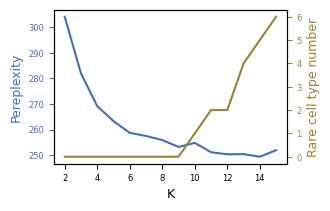

In [7]:
# Plot cell type number K versus perplexity and rare cell type number
cell_type_num = df_deconvolution_data.iloc[:, 0]
ppl = df_deconvolution_data.iloc[:, 2]
rare_cell_type_num = df_deconvolution_data.iloc[:, 1]
visualize_lineplot(cell_type_num, ppl, rare_cell_type_num)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

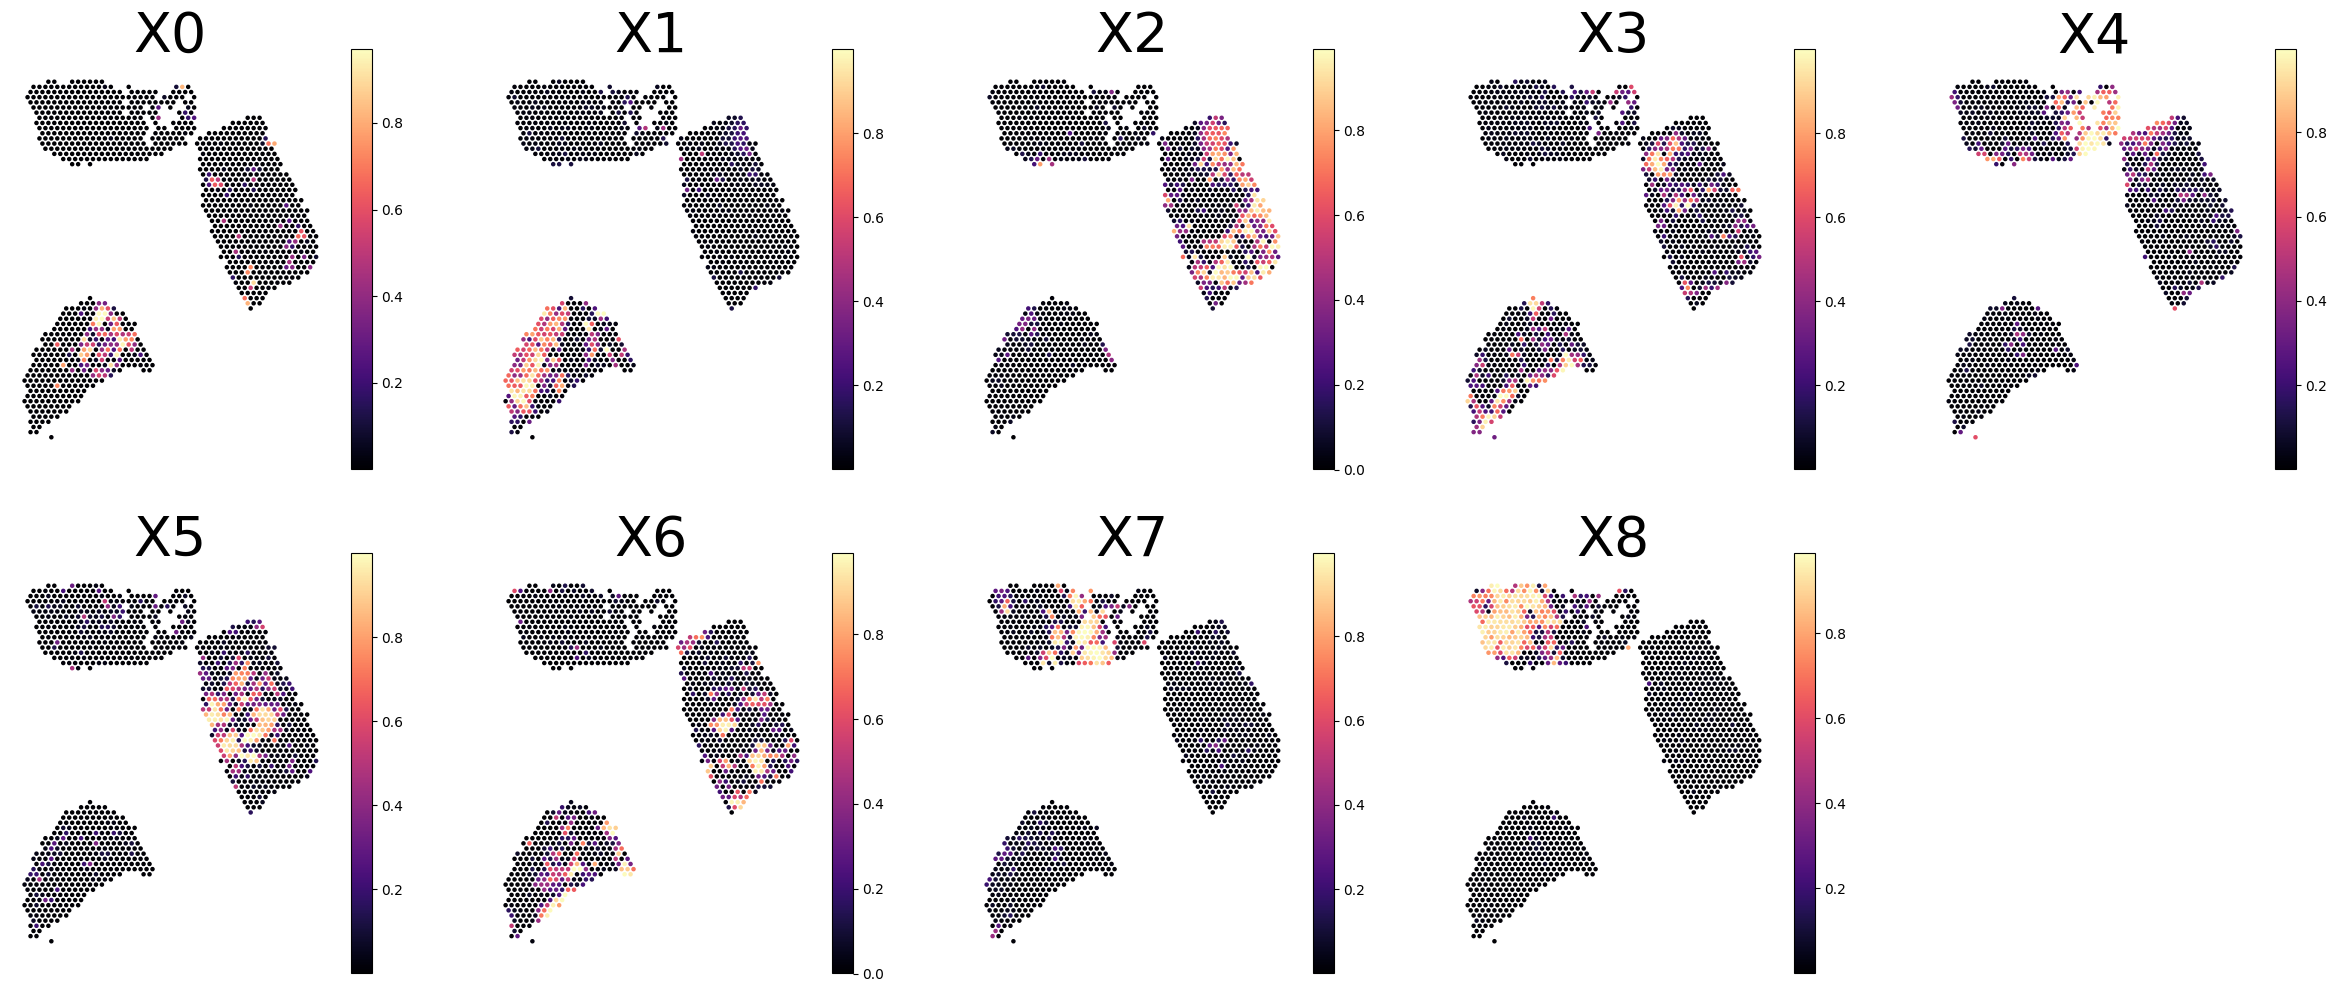

In [8]:
# Choose a suitable cell_type_num for further visualization (The optimal cell type number K is determined at the point where reaches the lowest perplexity while minimizing the rare cell type number ideally. It is reconmmended to choose the cell type number with a low perplexity but not very high rare cell type number (For example, less than 3. If you want to explore more cell types, a higher rare cell type number is acceptable). Moreover, the user can choose the optimal K with the help their biology knowledge.)
cell_type_num = 9
df_pred_ = pd.read_csv(results_dir + f'/prediction_save/cell_type_num_{cell_type_num}/pred.csv')
# df_pred_ = pd.read_csv(results_dir + f'/test_save/cell_type_num_{cell_type_num}/pred.csv')
df_pos_ = df_pp_data.iloc[:, 1:3]
celltype_visualization_visium(df_pred_, df_pos_, col_num=5)